# Caveats, differences from main PWWB repo, concerns
- Bounding boxes are different. In other places it's: `-118.75, 33.5, -117.5, 34.5`, in others it's `33.6, 34.3, -118.6, -117.9`. I don't know why the differences are here, so I'll just use the later.
- In the training notebook, the labels were just the stations, not the interpolated grid.
    - I'm thinking we do the same: we have hrrr + interpolated airnow, and the label will be the 9 sensors. We can just interpolate the output if we want to.
- I'm confused, we're predicting something called "value" instead of AQI. I don't know the relationship between these two numbers.
    - also what is value vs aqi?? its not even on the docs https://docs.airnowapi.org/Data/docs like what

# Accessing the data
Using the AirNow API, we'll request a json of the data we need.

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

lat_bottom, lat_top = 33.6, 34.3
lon_bottom, lon_top = -118.6, -117.9
dim = 40

# get airnow data
if os.path.exists('airnow.json'):
    print("airnow.json already exists; skipping request...")
else:
    date_start = '2025-01-10T00'
    date_end = '2025-01-16T23'
    bbox = f'{lon_bottom},{lat_bottom},{lon_top},{lat_top}'
    airnow_api_key = 'D73B0C80-2A31-40D8-955F-9B00DF659AE0'#print("YOU NEED TO ADD YOUR API KEY!")
    URL = "https://www.airnowapi.org/aq/data"
    
    # location given here
    
    # defining a params dict for the parameters to be sent to the API
    PARAMS = {
        'startDate':date_start,
        'endDate':date_end,
        'parameters':'PM25',
        'BBOX':bbox,
        'dataType':'B',
        'format':'application/json',
        'verbose':'0',
        'monitorType':'2',
        'includerawconcentrations':'1',
        'API_KEY':airnow_api_key
    }
    
    # sending get request and saving the response as response object
    response = requests.get(url = URL, params = PARAMS)

    # extracting data in json format
    airnow_data = response.json()
    with open('airnow.json', 'w') as file:
        json.dump(airnow_data, file)
        print("JSON data saved to airnow.json")
    
# open json file and convert to dataframe
with open('airnow.json', 'r') as file:
    airnow_data = json.load(file)
airnow_df = pd.json_normalize(airnow_data)
airnow_df[0:20]

JSON data saved to airnow.json


,Latitude,Longitude,UTC,Parameter,Unit,Value,RawConcentration,AQI,Category
0,34.199200,-118.533100,2025-01-10T00:00,PM2.5,UG/M3,2.9,1.2,16,1
1,34.181977,-118.363036,2025-01-10T00:00,PM2.5,UG/M3,60.5,53.2,155,4
2,34.066429,-118.226755,2025-01-10T00:00,PM2.5,UG/M3,55.3,50.4,150,3
3,33.901400,-118.205000,2025-01-10T00:00,PM2.5,UG/M3,21.6,12.2,74,2
4,33.793713,-118.171019,2025-01-10T00:00,PM2.5,UG/M3,21.6,10.8,74,2
5,33.830586,-117.938509,2025-01-10T00:00,PM2.5,UG/M3,36.6,40.0,104,3
6,34.199200,-118.533100,2025-01-10T01:00,PM2.5,UG/M3,1.3,-0.3,7,1
7,34.181977,-118.363036,2025-01-10T01:00,PM2.5,UG/M3,58.4,56.3,153,4
8,34.066429,-118.226755,2025-01-10T01:00,PM2.5,UG/M3,55.6,55.9,151,4
9,33.901400,-118.205000,2025-01-10T01:00,PM2.5,UG/M3,22.8,24.1,77,2


This should generate a URL like this:
```
https://www.airnowapi.org/aq/data/?startDate=2025-01-10T00&endDate=2025-01-16T23&parameters=PM25&BBOX=-118.6,33.6,-117.9,34.3&dataType=B&format=application/json&verbose=0&monitorType=2&includerawconcentrations=1&API_KEY=YOUR-API-KEY-HERE
```

You can also use a query tool from AirNow:
- https://docs.airnowapi.org/Data/query

In [2]:
# group data by time; every element in the list is a single frame containing 9 stations
list_df = [group for name, group in airnow_df.groupby('UTC')]
print(f"Number of frames: {len(list_df)}")
display(list_df[0])
display(list_df[-1])

Number of frames: 168


,Latitude,Longitude,UTC,Parameter,Unit,Value,RawConcentration,AQI,Category
0,34.199200,-118.533100,2025-01-10T00:00,PM2.5,UG/M3,2.9,1.2,16,1
1,34.181977,-118.363036,2025-01-10T00:00,PM2.5,UG/M3,60.5,53.2,155,4
2,34.066429,-118.226755,2025-01-10T00:00,PM2.5,UG/M3,55.3,50.4,150,3
3,33.901400,-118.205000,2025-01-10T00:00,PM2.5,UG/M3,21.6,12.2,74,2
4,33.793713,-118.171019,2025-01-10T00:00,PM2.5,UG/M3,21.6,10.8,74,2
5,33.830586,-117.938509,2025-01-10T00:00,PM2.5,UG/M3,36.6,40.0,104,3


,Latitude,Longitude,UTC,Parameter,Unit,Value,RawConcentration,AQI,Category
961,34.199200,-118.533100,2025-01-16T23:00,PM2.5,UG/M3,0.0,0.0,0,1
962,34.181977,-118.363036,2025-01-16T23:00,PM2.5,UG/M3,5.7,6.9,32,1
963,34.066429,-118.226755,2025-01-16T23:00,PM2.5,UG/M3,5.9,4.0,33,1
964,33.901400,-118.205000,2025-01-16T23:00,PM2.5,UG/M3,3.3,4.5,18,1
965,33.793713,-118.171019,2025-01-16T23:00,PM2.5,UG/M3,4.2,2.9,23,1
966,33.830586,-117.938509,2025-01-16T23:00,PM2.5,UG/M3,7.1,7.4,39,1


# Interpolate

In [3]:
def preprocess_ground_sites(df, dim, latMax, latMin, lonMax, lonMin):
    latDist, lonDist = abs(latMax - latMin), abs(lonMax - lonMin)
    unInter = np.zeros((dim,dim))
    dfArr = np.array(df[['Latitude','Longitude','Value']])
    for i in range(dfArr.shape[0]):
        # Calculate x
        x = int(((latMax - dfArr[i,0]) / latDist) * dim)
        if x >= dim:
            x = dim - 1
        if x <= 0:
            x = 0
        # Calculate y
        y = dim - int(((lonMax + abs(dfArr[i,1])) / lonDist) * dim)
        if y >= dim:
            y = dim - 1
        if y <= 0:
            y = 0
        if dfArr[i,2] < 0:
            unInter[x,y] = 0
        else:
            unInter[x,y] = dfArr[i,2]
    return unInter

Three random frames of Grid-based AirNow Data


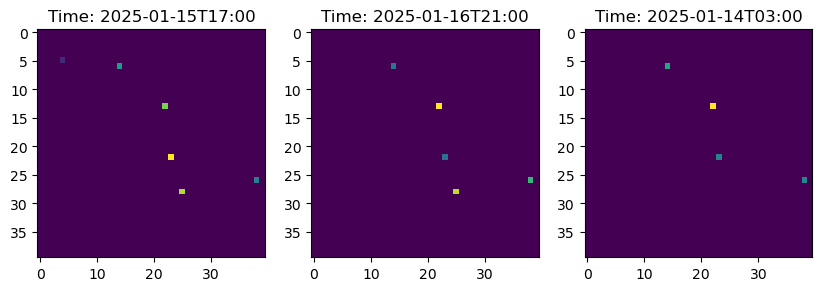

In [4]:
# preprocess ground sites -- converting dataframe of stations into a grid
list_unInter = [preprocess_ground_sites(df, dim, lat_top, lat_bottom, lon_top, lon_bottom) for df in list_df]

# plot out 3 random images
np.random.seed(42)
print("Three random frames of Grid-based AirNow Data")
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for idx, ax in enumerate(axes):
    randIdx = np.random.choice(range(0, len(list_unInter)), replace=False)
    ax.imshow(list_unInter[randIdx])
    ax.set_title(f"Time: {list_df[randIdx]['UTC'].iloc[0]}")    

plt.show()

By printing the x and y values in the preprocessing function, we find the locations of the sensors on the grid we've created.

Furthermore, if we set `verbose=1` when we send our API request, we get location information for these sensors, under `SiteName`:
- Reseda: (5, 4)
- North Holywood (sic): (6, 14)
- Los Angeles - N. Main Street: (13, 22)
- Compton: (22, 23)
- Long Beach Signal Hill: (28, 25)
- Anaheim: (26, 38)

In [5]:
airnow_sens_loc = {
    'Reseda': (5, 4),
    'North Holywood (sic)': (6, 14),
    'Los Angeles - N. Main Street': (13, 22),
    'Compton': (22, 23),
    'Long Beach Signal Hill': (28, 25),
    'Anaheim': (26, 38),
}

In [6]:
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator

def interpolate_frame(f, dim):
    i = 0
    interpolated = []
    count = 0
    idx = 0
    x_list = []
    y_list = []
    values = []
    for x in range(f.shape[0]):
        for y in range(f.shape[1]):
            if f[x,y] != 0:
                x_list.append(x)
                y_list.append(y)
                values.append(f[x,y])
    coords = list(zip(x_list,y_list))
    try:
        interp = NearestNDInterpolator(coords, values)
        X = np.arange(0,dim)
        Y = np.arange(0,dim)
        X, Y = np.meshgrid(X, Y)
        Z = interp(X, Y)
    except ValueError:
        Z = np.zeros((dim,dim))
    interpolated = Z
    count += 1
    i += 1
    interpolated = np.array(interpolated)
    return interpolated

Three random frames of Interpolated Grid-based AirNow Data


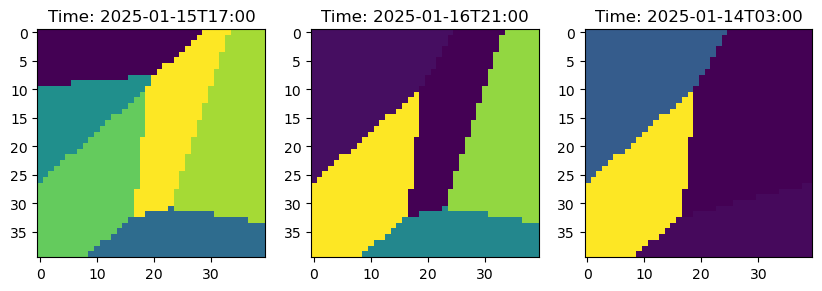

In [7]:
# interpolate
list_inter = [interpolate_frame(unInter, dim) for unInter in list_unInter]

# print 3 frames
np.random.seed(42)
print("Three random frames of Interpolated Grid-based AirNow Data")
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for idx, ax in enumerate(axes):
    randIdx = np.random.choice(range(0, len(list_inter)), replace=False)
    ax.imshow(list_inter[randIdx])
    ax.set_title(f"Time: {list_df[randIdx]['UTC'].iloc[0]}")    
    
plt.show()

# Scale

Three random frames of Scaled Interpolated Grid-based AirNow Data


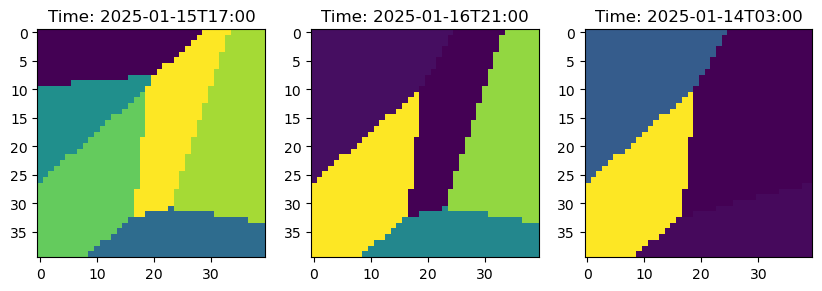

In [8]:
# we scale each sample relative to other samples
def std_scale(data):
    mean = np.mean(data)
    stddev = np.std(data)
    return (data - mean) / stddev
    
scaled_frames = std_scale(np.array(list_inter))

# print 3 frames
np.random.seed(42)
print("Three random frames of Scaled Interpolated Grid-based AirNow Data")
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for idx, ax in enumerate(axes):
    randIdx = np.random.choice(range(0, len(scaled_frames)), replace=False)
    ax.imshow(scaled_frames[randIdx])
    ax.set_title(f"Time: {list_df[randIdx]['UTC'].iloc[0]}")    
    
plt.show()

In [9]:
# ensure actual scaling has occurred
randIdx = np.random.choice(range(0, len(list_inter)), replace=False)
print(f"Examining data at frame {randIdx}\n")
print("Interpolated data:")
print(list_inter[randIdx], '\n')
print("Interpolated and scaled data:")
print(scaled_frames[randIdx])

Examining data at frame 87

Interpolated data:
[[ 0.3  0.3  0.3 ... 21.2 21.2 21.2]
 [ 0.3  0.3  0.3 ... 21.2 21.2 21.2]
 [ 0.3  0.3  0.3 ... 21.2 21.2 21.2]
 ...
 [12.9 12.9 12.9 ...  1.   1.   1. ]
 [12.9 12.9 12.9 ...  1.   1.   1. ]
 [12.9 12.9 12.9 ...  1.   1.   1. ]] 

Interpolated and scaled data:
[[-1.00298451 -1.00298451 -1.00298451 ...  0.4041607   0.4041607
   0.4041607 ]
 [-1.00298451 -1.00298451 -1.00298451 ...  0.4041607   0.4041607
   0.4041607 ]
 [-1.00298451 -1.00298451 -1.00298451 ...  0.4041607   0.4041607
   0.4041607 ]
 ...
 [-0.15465773 -0.15465773 -0.15465773 ... -0.95585524 -0.95585524
  -0.95585524]
 [-0.15465773 -0.15465773 -0.15465773 ... -0.95585524 -0.95585524
  -0.95585524]
 [-0.15465773 -0.15465773 -0.15465773 ... -0.95585524 -0.95585524
  -0.95585524]]


# Visualizing preprocessed, interpolated, and scaled data

Frame: 57, Time: 2025-01-12T09:00


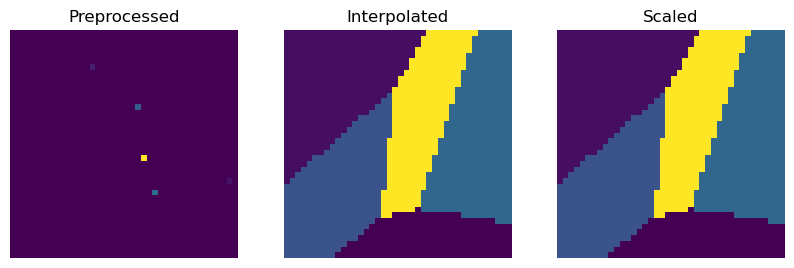

In [10]:
# compare all 3 levels
randIdx = np.random.choice(range(0, len(list_inter)), replace=False)
compare = [
    ("Preprocessed", list_unInter[randIdx]), 
    ("Interpolated", list_inter[randIdx]), 
    ("Scaled", scaled_frames[randIdx])
]
print(f"Frame: {randIdx}, Time: {list_df[randIdx]['UTC'].iloc[0]}")
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for idx, ax in enumerate(axes):
    ax.imshow(compare[idx][1])
    ax.set_title(compare[idx][0])
    ax.axis("off")
    
plt.show()

# Convert data into 5D tensor

In [11]:
# create a channel axis
print(f"Shape of scaled frames: {scaled_frames.shape}")

frames = np.expand_dims(scaled_frames, axis=-1)

print(f"Shape of scaled frames with channel axis: {frames.shape}")

# create samples from frames
def sliding_window_of(frames, sample_size, rows, cols, channels):
    n_samples = len(frames) - sample_size
    samples = np.empty((n_samples, sample_size, rows, cols, channels))
    for i in range(n_samples):
        samples[i] = np.array([frames[j] for j in range(i, i + sample_size)])
    return samples

complete_dataset = sliding_window_of(frames=frames, sample_size=5, rows=dim, cols=dim, channels=1)
print(f"Shape of the final input: {complete_dataset.shape}")

Shape of scaled frames: (168, 40, 40)
Shape of scaled frames with channel axis: (168, 40, 40, 1)
Shape of the final input: (163, 5, 40, 40, 1)


# Generate final input

In [12]:
n_samples, n_frames, n_channels = 1, 1, 2
payload = np.zeros((n_samples, n_frames, dim, dim, n_channels))
payload[0, 0, :, :, 0] = frames
# payload[0, 0, :, :, 1] = scaled_hrrr ??
# also guessing that since this is from the inference script, shape will be (1, 1, 40, 40, 2); 1 sample, 1 frame (is not 5?), 40x40, 2 channels

ValueError: could not broadcast input array from shape (168,40,40,1) into shape (40,40)